# 5章: バンディットアルゴリズム: テスト中の損失にも向き合う

必要なモジュールの読み込み

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import tqdm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

/var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/ipykernel_7749/3038471587.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## $\varepsilon$ -greedyアルゴリズム

In [1]:
n_arms = 4

class Env(object):
  thetas = [0.1, 0.1, 0.2, 0.3]

  def react(arm):
    return 1 if np.random.random() < Env.thetas[arm] else 0

  def opt():
    return np.argmax(Env.thetas)

In [2]:
class EpsilonGreedyAgent(object):

  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def get_arm(self):
    if np.random.random() < self.epsilon:
      arm = np.random.randint(n_arms)
    else:
      arm = np.argmax(self.values)
    return arm

  def sample(self, arm, reward):
    self.counts[arm] += 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [31]:
def sim(Agent, N=1000, T=1000, **kwargs):
  selected_arms = [[0 for _ in range(T)] for _ in range(N)]
  earned_rewards = [[0 for _ in range(T)] for _ in range(N)]

  for n in tqdm.tqdm(range(N)):
    agent = Agent(**kwargs)
    for t in range(T):
      arm = agent.get_arm()
      reward = Env.react(arm)
      agent.sample(arm, reward)
      selected_arms[n][t] = arm
      earned_rewards[n][t] = reward
  return np.array(selected_arms), np.array(earned_rewards)

$\varepsilon$ -greedyアルゴリズムの正解率の推移

100%|██████████| 1000/1000 [00:02<00:00, 356.34it/s]


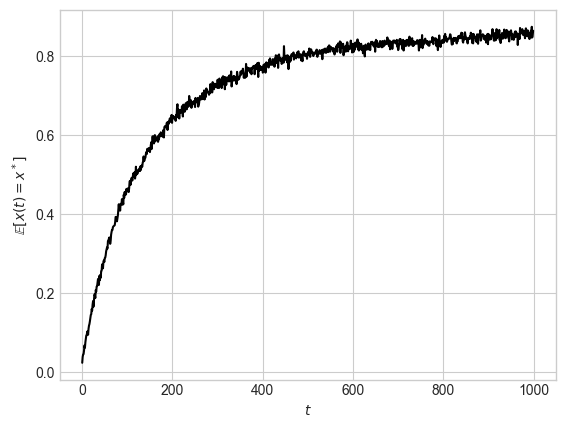

In [32]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)

plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.show()

In [33]:
class OracleAgent(object):
  def __init__(self):
    self.arm = Env.opt()

  def get_arm(self):
    return self.arm

  def sample(self, arm, reward):
    pass

$\varepsilon$-greedyと全知全能エージェントの累積報酬の比較

100%|██████████| 1000/1000 [00:00<00:00, 2816.62it/s]


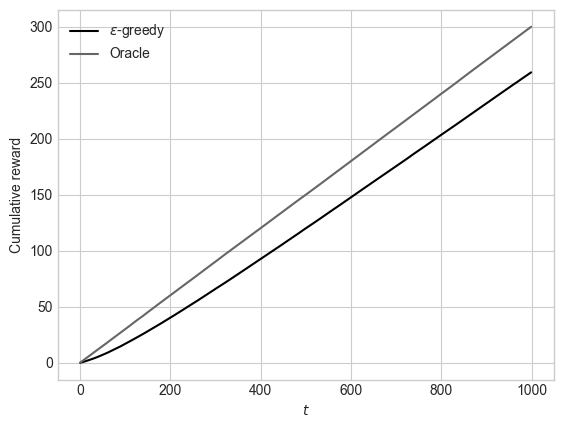

In [34]:
arms_o, rewards_o = sim(OracleAgent)
plt.plot(np.mean(np.cumsum(rewards_eg, axis=1), axis=0),
          label=r'$\varepsilon$-greedy')
plt.plot(np.mean(np.cumsum(rewards_o, axis=1), axis=0), label=r'Oracle')
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

## 焼きなまし $\varepsilon$-greedyアルゴリズム

In [35]:
class AnnealingEpsilonGreedyAgent(object):

  def __init__(self, epsilon=1.0):
    self.epsilon = epsilon
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def get_arm(self):
    if np.random.random() < self.epsilon:
      arm = np.random.randint(n_arms)
    else:
      arm = np.argmax(self.values)
    self.epsilon *= 0.99
    return arm

  def sample(self, arm, reward):
    self.counts[arm] += 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

焼きなまし$\varepsilon$ -greedyアルゴリズムの正解率の推移

100%|██████████| 1000/1000 [00:02<00:00, 357.40it/s]


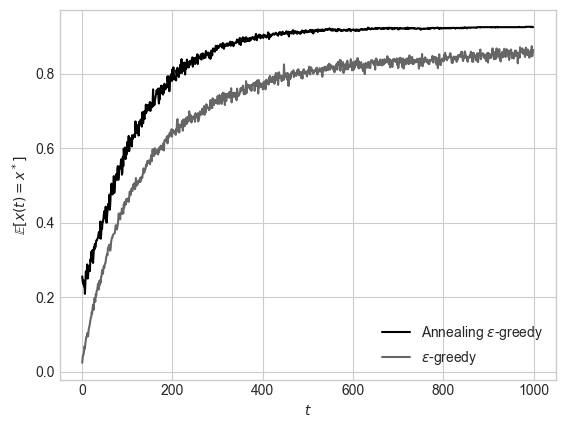

In [36]:
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)

plt.plot(np.mean(arms_aeg == Env.opt(), axis=0),
          label=r'Annealing $\varepsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0),
          label=r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

## ソフトマックスアルゴリズム

In [37]:
class SoftmaxAgent(object):

  def __init__(self, tau=.05):
    self.tau = tau
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def softmax_p(self):
    logit = self.values / self.tau
    logit = logit - np.max(logit)
    p = np.exp(logit) / sum(np.exp(logit))
    return p

  def get_arm(self):
    arm = np.random.choice(n_arms, p=self.softmax_p())
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

ソフトマックスアルゴリズムの正解率の推移


100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]


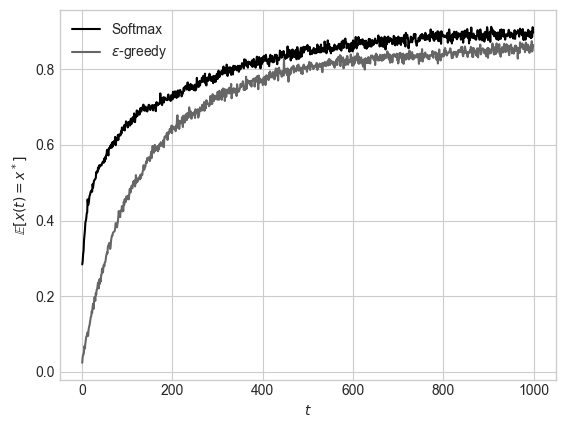

In [38]:
arms_sm, rewards_sm = sim(SoftmaxAgent)

plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label=r'Softmax')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0),
          label=r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [39]:
class AnnealingSoftmaxAgent(object):

  def __init__(self, tau=1000.):
    self.tau = tau
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def softmax_p(self):
    logit = self.values / self.tau
    logit = logit - np.max(logit)
    p = np.exp(logit) / sum(np.exp(logit))
    return p

  def get_arm(self):
    arm = np.random.choice(n_arms, p=self.softmax_p())
    self.tau = self.tau * 0.9
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

焼きなましソフトマックスアルゴリズムの正解率の推移

100%|██████████| 1000/1000 [00:15<00:00, 66.22it/s]


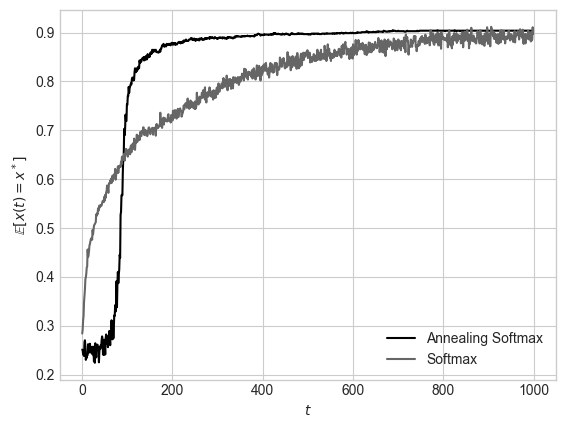

In [40]:
arms_asm, rewards_asm = sim(AnnealingSoftmaxAgent)

plt.plot(np.mean(arms_asm == Env.opt(), axis=0),
          label='Annealing Softmax')
plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label='Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

## トンプソン抽出

In [41]:
class BernoulliTSAgent(object):

  def __init__(self):
    self.counts = [0 for _ in range(n_arms)]
    self.wins = [0 for _ in range(n_arms)]

  def get_arm(self):
    beta = lambda N, a: np.random.beta(a + 1, N - a + 1)
    result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
    arm = result.index(max(result))
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.wins[arm] = self.wins[arm] + reward

トンプソン抽出の正解率の推移

100%|██████████| 1000/1000 [00:03<00:00, 309.56it/s]


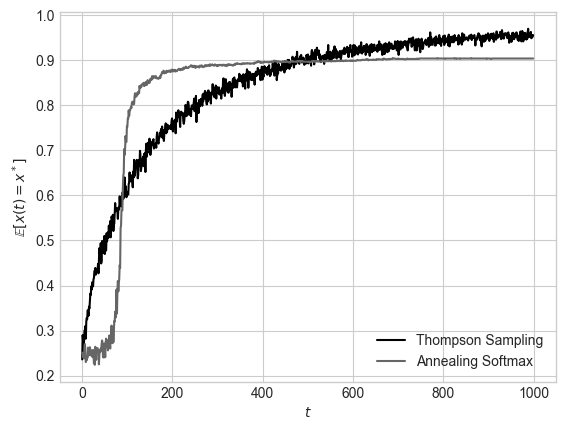

In [42]:
arms_ts, rewards_ts = sim(BernoulliTSAgent)

plt.plot(np.mean(arms_ts == Env.opt(), axis=0),
          label='Thompson Sampling')
plt.plot(np.mean(arms_asm == Env.opt(), axis=0),
          label='Annealing Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

## UCBアルゴリズム

In [43]:
class UCBAgent(object):

  def __init__(self):
    self.counts = [0 for _ in range(n_arms)]
    self.values = [0 for _ in range(n_arms)]

  def calc_ucb(self, arm):
    ucb = self.values[arm]
    ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
    return ucb

  def get_arm(self):
    if 0 in self.counts:
      arm = self.counts.index(0)
    else:
      ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
      arm = ucb.index(max(ucb))
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

UCBアルゴリズムの正解率の推移

100%|██████████| 1000/1000 [00:05<00:00, 180.79it/s]


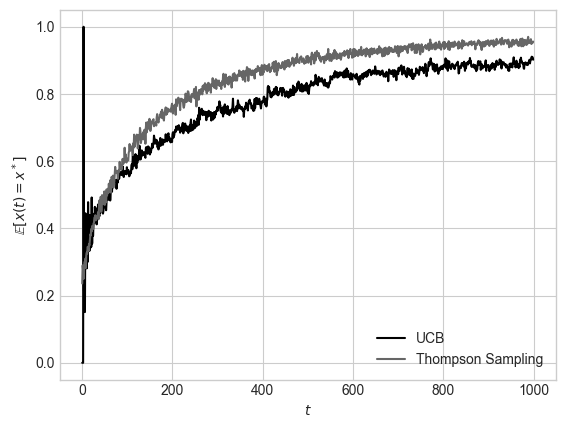

In [44]:
arms_ucb, rewards_ucb = sim(UCBAgent)

plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label='UCB')
plt.plot(np.mean(arms_ts == Env.opt(), axis=0),
          label='Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()